## Simulator

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1000/1000 [00:00<00:00, 1402.58it/s]


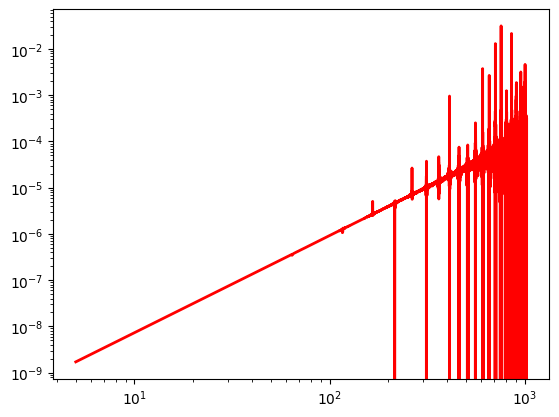

In [2]:
# Simluate data 
n_samples = 1000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

Text(0.5, 1.0, 'Example Observation: Variance by Frequency')

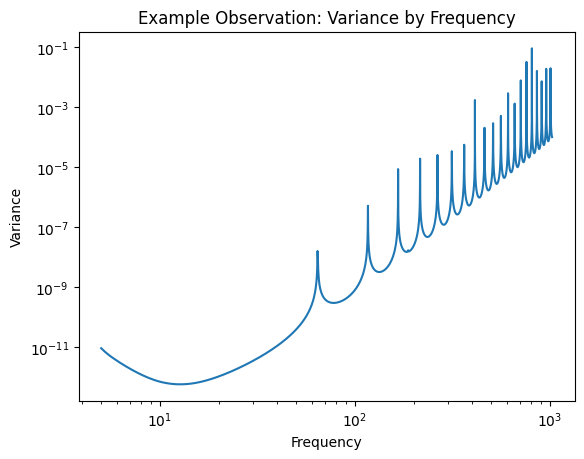

In [38]:
plt.loglog(sim.freq,samples[5]['sigma'])
plt.xlabel("Frequency")
plt.ylabel("Variance")
plt.title("Example Observation: Variance vs. Frequency")

Text(0, 0.5, 'Log Omega')

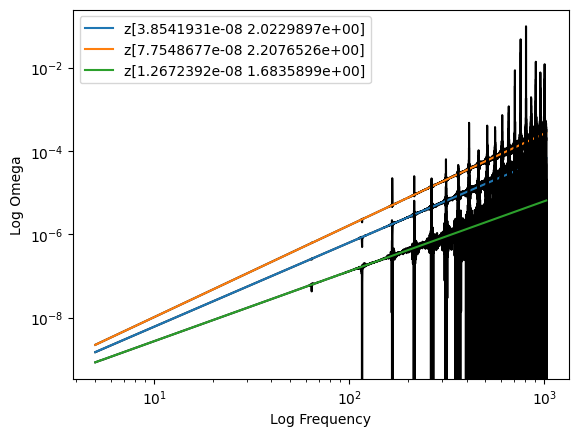

In [48]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()
plt.xlabel("Log Frequency")
plt.ylabel("Log Omega")

In [5]:
sim.freq

array([   5.       ,    5.2501227,    5.5002454, ..., 1023.7497546,
       1023.9998773, 1024.25     ])

In [6]:
samples['x']

array([[ 2.2609870e-08,  2.3366717e-08,  2.4084287e-08, ...,
        -1.1928896e-04,  2.2265394e-05, -6.5030267e-06],
       [ 6.2221099e-09,  6.3499499e-09,  6.4787993e-09, ...,
        -8.8514091e-05, -7.8023957e-05, -4.0052371e-05],
       [ 2.2251549e-09,  2.4769129e-09,  2.7452540e-09, ...,
         1.8321336e-04,  1.8046735e-04,  3.6932857e-04],
       ...,
       [ 1.9623377e-10,  1.9438930e-10,  2.3419963e-10, ...,
         1.2347250e-03,  1.2931884e-03,  1.2409148e-03],
       [ 2.7125646e-09,  2.9705509e-09,  3.2304328e-09, ...,
         6.8726076e-05,  1.3890298e-05,  3.0814899e-05],
       [ 1.8683888e-08,  1.9317826e-08,  1.9938788e-08, ...,
        -5.2583641e-06, -1.8905284e-04, -4.7781996e-05]], dtype=float32)

## Variational Autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4076, 1024)
        self.encoder_fc2 = nn.Linear(1024, 256)
        self.encoder_fc3 = nn.Linear(256, 64)
        self.encoder_fc4 = nn.Linear(64, 16)

        # Latent space mean and log variance
        self.fc_mu = nn.Linear(16, 8)
        self.fc_logvar = nn.Linear(16, 8)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(8, 16)
        self.decoder_fc2 = nn.Linear(16, 64)
        self.decoder_fc3 = nn.Linear(64, 256)
        self.decoder_fc4 = nn.Linear(256, 1024)
        self.decoder_fc5 = nn.Linear(1024, 4076)

        self.dropout = nn.Dropout(0.2)

    def encode(self, x):
        # Encode input to latent space
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        x = F.relu(self.encoder_fc3(x))
        x = F.relu(self.encoder_fc4(x))

        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z

    def decode(self, z):
        # Decode the sampled latent vector
        z = F.relu(self.decoder_fc1(z))
        z = F.relu(self.decoder_fc2(z))
        z = F.relu(self.decoder_fc3(z))
        z = F.relu(self.decoder_fc4(z))
        z = self.decoder_fc5(z)
        return z

    def forward(self, x):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


# Instantiate and print summary
model = VAE()
summary(model, input_size=(1, 4076))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]       4,174,848
            Linear-2               [-1, 1, 256]         262,400
            Linear-3                [-1, 1, 64]          16,448
            Linear-4                [-1, 1, 16]           1,040
            Linear-5                 [-1, 1, 8]             136
            Linear-6                 [-1, 1, 8]             136
           Dropout-7                 [-1, 1, 8]               0
            Linear-8                [-1, 1, 16]             144
            Linear-9                [-1, 1, 64]           1,088
           Linear-10               [-1, 1, 256]          16,640
           Linear-11              [-1, 1, 1024]         263,168
           Linear-12              [-1, 1, 4076]       4,177,900
Total params: 8,913,948
Trainable params: 8,913,948
Non-trainable params: 0
---------------------------

In [8]:
# Pre-Process Data

from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

x_samples = samples['x'] 
m_samples = samples['m']

#Split into test and train
x_train, x_test, m_train, m_test = train_test_split(x_samples, m_samples, test_size=0.1)

# Scaling data across each sample (need to transpose first)
transposed_x_train = x_train.T
transposed_m_train = m_train.T
transposed_x_test = x_test.T
transposed_m_test = m_test.T

scaler_x_train = StandardScaler() 
scaler_m_train = StandardScaler()
scaler_x_test = StandardScaler() 
scaler_m_test = StandardScaler()

x_T_scaled_train = scaler_x_train.fit_transform(transposed_x_train)
m_T_scaled_train = scaler_m_train.fit_transform(transposed_m_train)
x_T_scaled_test = scaler_x_test.fit_transform(transposed_x_test)
m_T_scaled_test = scaler_m_test.fit_transform(transposed_m_test)

x_scaled_train = x_T_scaled_train.T
m_scaled_train = m_T_scaled_train.T
x_scaled_test = x_T_scaled_test.T
m_scaled_test = m_T_scaled_test.T


# Convert to tensors
x_train_tensor = torch.tensor(x_scaled_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_scaled_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_scaled_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_scaled_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_15621/3536314854.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
x_train_tensor.shape

torch.Size([900, 4076])

In [10]:
# Check that normalization worked
print("Min: ",np.min(x_scaled_test[0,:]))
print("Max: ",np.max(x_scaled_test[0,:]))
print("Mean: ",np.average(x_scaled_test[0,:]))
print("Var: ", np.var(x_scaled_test[0,:]))

Min:  -22.919462
Max:  47.45995
Mean:  -9.358924e-10
Var:  1.0000001


In [11]:
print("Min: ",np.min(x_scaled_train[0,:]))
print("Max: ",np.max(x_scaled_train[0,:]))
print("Mean: ",np.average(x_scaled_train[0,:]))
print("Var: ", np.var(x_scaled_train[0,:]))

Min:  -15.653629
Max:  56.992092
Mean:  0.0
Var:  1.0000001


In [12]:
x_scaled_train.shape

(900, 4076)

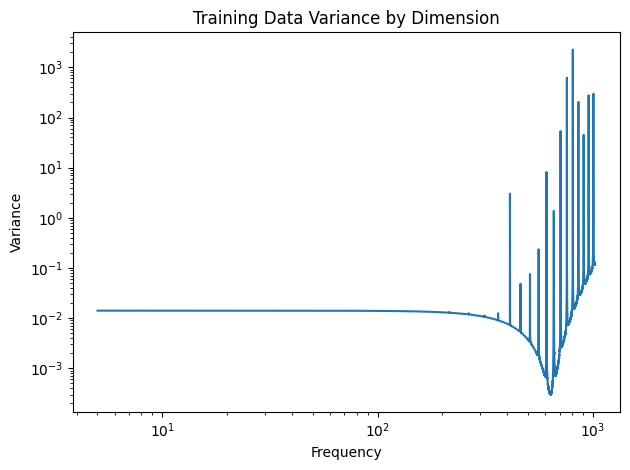

In [39]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = Var_By_Column(x_scaled_test)
sig_train = Var_By_Column(x_scaled_train)

plt.loglog(sim.freq,sig_train)



plt.ylabel("Variance")
plt.xlabel("Frequency")
plt.title("Training Data Variance by Frequency")
plt.tight_layout()

plt.show()


#plt.plot(sig_train, c="r")

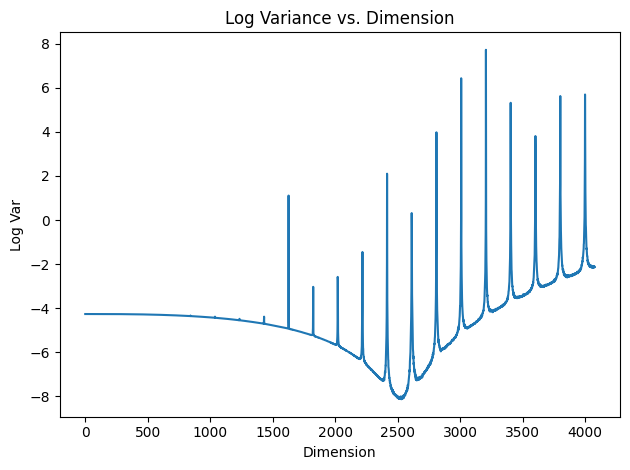

In [47]:

# Create the plot
plt.plot(np.log(sig_train), label='Smoothed Variance')

plt.ylabel("Log Var")
plt.xlabel("Dimension")
plt.title("Log Variance vs. Dimension")
plt.tight_layout()

plt.show()


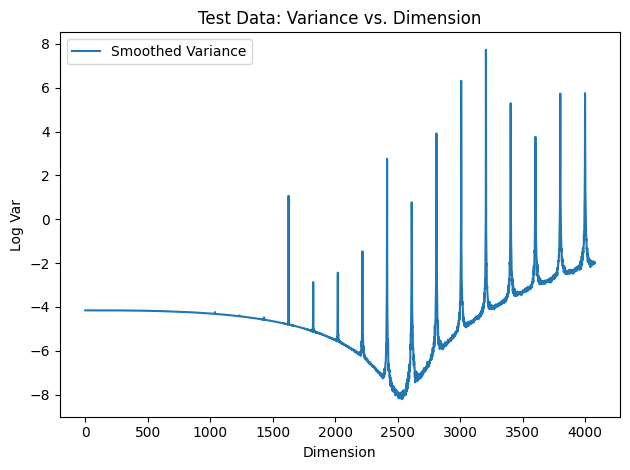

In [44]:
# Create the plot
plt.plot(np.log(sig_test), label='Smoothed Variance')

plt.ylabel("Log Var")
plt.xlabel("Dimension")
plt.title("Test Data: Variance vs. Dimension")
plt.tight_layout()
plt.legend()
plt.show()


In [43]:
print(sig_train-sig_test)

[-0.00160517 -0.00160517 -0.00160517 ... -0.02432691 -0.00898006
 -0.02099478]


In [21]:
sig_train


array([0.014102  , 0.01410201, 0.01410202, ..., 0.11682136, 0.12251114,
       0.11921991])

In [14]:
# VAE Weighted Loss
def VAE_WeightedLoss(sigma, predictions, targets, mu, logvar):
    """
    Computes the total loss for a Variational Autoencoder (VAE), including:
    - Weighted Mean Squared Error (MSE) loss between predictions and targets.
    - Kullback-Leibler Divergence (KL divergence) to regularize the latent space.
    
    Args:
        sigma (list or torch.Tensor): The variance weights for each dimension.
        predictions (torch.Tensor): The reconstructed values from the VAE.
        targets (torch.Tensor): The target (original input) values.
        mu (torch.Tensor): The mean of the latent space distribution.
        logvar (torch.Tensor): The log variance of the latent space distribution.
        
    Returns:
        torch.Tensor: The total loss, combining weighted MSE loss and KL divergence.
    """
    #ensure sigma is a tensor if it is not already
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.Tensor(sigma)

    #ensure predictons and targets have same shape
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    # Weighted Mean Squared Error loss
    squared_error = 1 / sigma**2 * (predictions - targets)**2
    weighted_mse_loss = torch.mean(squared_error)

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: MSE + KL divergence
    total_loss = weighted_mse_loss + kl_divergence

    return total_loss


In [15]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Variational Autoencoder
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate
sig_train = sig_train  # list of variances per feature

train_losses = []
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass through the VAE
        outputs, mu, logvar = model(inputs.unsqueeze(1))  # Outputs, mu, logvar

        # Compute the loss
        loss = VAE_WeightedLoss(sig_train, outputs, targets.unsqueeze(1), mu, logvar)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * inputs.size(0)

    # Compute the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")

# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Epoch [1/50], Loss: 36521.4786111111
Epoch [2/50], Loss: 17406.9870486111
Epoch [3/50], Loss: 13568.5593446181
Epoch [4/50], Loss: 10739.4093663194
Epoch [5/50], Loss: 8290.8087022569
Epoch [6/50], Loss: 7575.4909722222
Epoch [7/50], Loss: 6269.5405794271
Epoch [8/50], Loss: 5433.3341927083
Epoch [9/50], Loss: 4487.2993006727
Epoch [10/50], Loss: 4210.3083957248
Epoch [11/50], Loss: 3572.4061336263
Epoch [12/50], Loss: 3557.9172612847


KeyboardInterrupt: 

In [ ]:
#torch.save(model,'VAE_model_pytorch_V2.pt')
model = torch.load('VAE_model_pytorch_V2.pt')

In [ ]:

model.eval()  
test_loss = 0.0
predictions = []

with torch.no_grad():  #disable gradient calculation for evaluation
    for inputs, targets in test_loader:

        outputs, mu, logvar = model(inputs.unsqueeze(1))
        loss = VAE_WeightedLoss(sig_test, outputs, targets.unsqueeze(1), mu, logvar)
        test_loss += loss.item() * inputs.size(0)
       # predictions.append(outputs.squeeze().numpy())

# average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 2882.0856


In [ ]:
import random
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Ensure the model is in evaluation mode
model.eval()
test_loss = 0.0
predictions = []
targets_list = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, targets in test_loader:
        outputs, mu, logvar = model(inputs.unsqueeze(1))

        # Collect predictions and targets
        predictions.append(outputs.squeeze().numpy())
        targets_list.append(targets.numpy())

        # Calculate the weighted loss (if needed, but not necessary for plotting)
        loss = VAE_WeightedLoss(sig_test, outputs, targets.unsqueeze(1), mu, logvar)
        test_loss += loss.item() * inputs.size(0)

# Average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Convert predictions and targets to numpy arrays
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets_list, axis=0)




Test Loss: 2904.4112


In [ ]:
test_size = np.int64(n_samples/10) # 10% test dataset

# Get means and sds from unscaled test dataset
target_means = np.mean(m_test, axis=1)
target_means = target_means.reshape(test_size,1)

target_sds = np.sqrt(np.var(m_test, axis=1))
target_sds = target_sds.reshape(test_size,1)

noisy_means = np.mean(x_test, axis=1)
noisy_means = target_means.reshape(test_size,1)

noisy_sds = np.sqrt(np.var(x_test, axis=1))
noisy_sds = target_sds.reshape(test_size,1)

# unscale the target dataset and predictions.
unscaled_targets = target_sds * targets + target_means
unscaled_predictions = noisy_sds * predictions + noisy_means # Use noisy means and sds


Test loss with basic model: 1601.3543
Test loss with more layers: 1365.7853

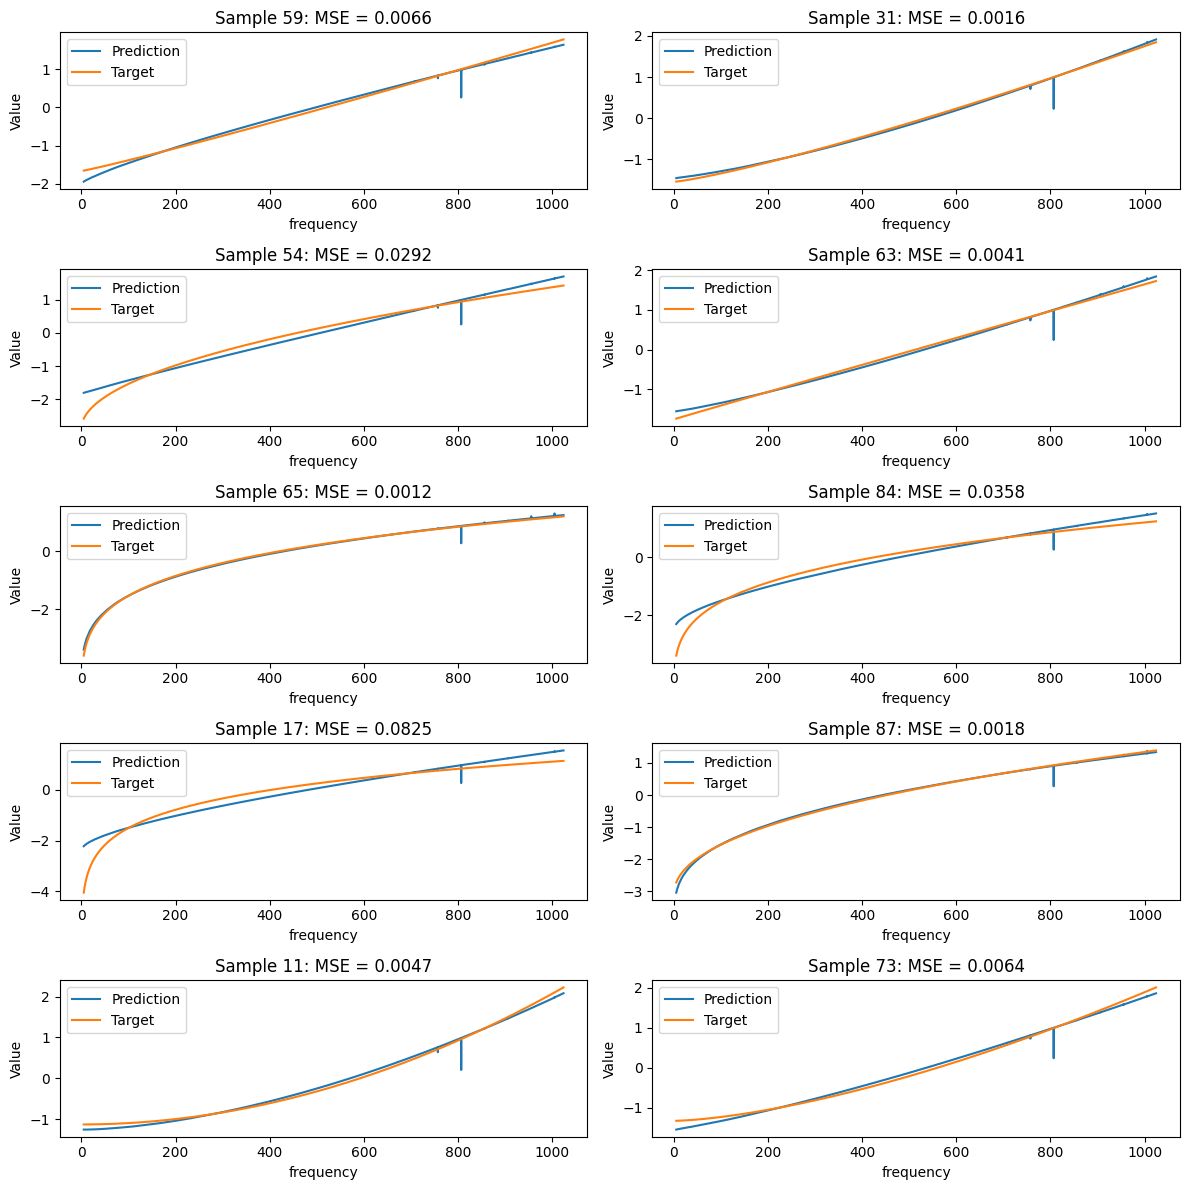

In [ ]:
import random
import matplotlib.pyplot as plt

# Randomly select 6 indices
num_samples = 10
random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 5
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0))  # extract prediction from model output

    mse = F.mse_loss(prediction.squeeze(), target).item() # calculate error

    # Plot prediction and target
    axs[row, col].plot(sim.freq,prediction.squeeze().numpy(), label='Prediction')
    axs[row, col].plot(sim.freq,target.numpy(), label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
sim.freq

array([   5.       ,    5.2501227,    5.5002454, ..., 1023.7497546,
       1023.9998773, 1024.25     ])

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_1698/779123421.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(prediction), torch.tensor(target)).item()
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_1698/779123421.py:39: UserWarning: Using a target size (torch.Size([4076])) that is different to the input size (torch.Size([1, 1, 4076])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(torch.tensor(prediction), torch.tensor(target)).item()


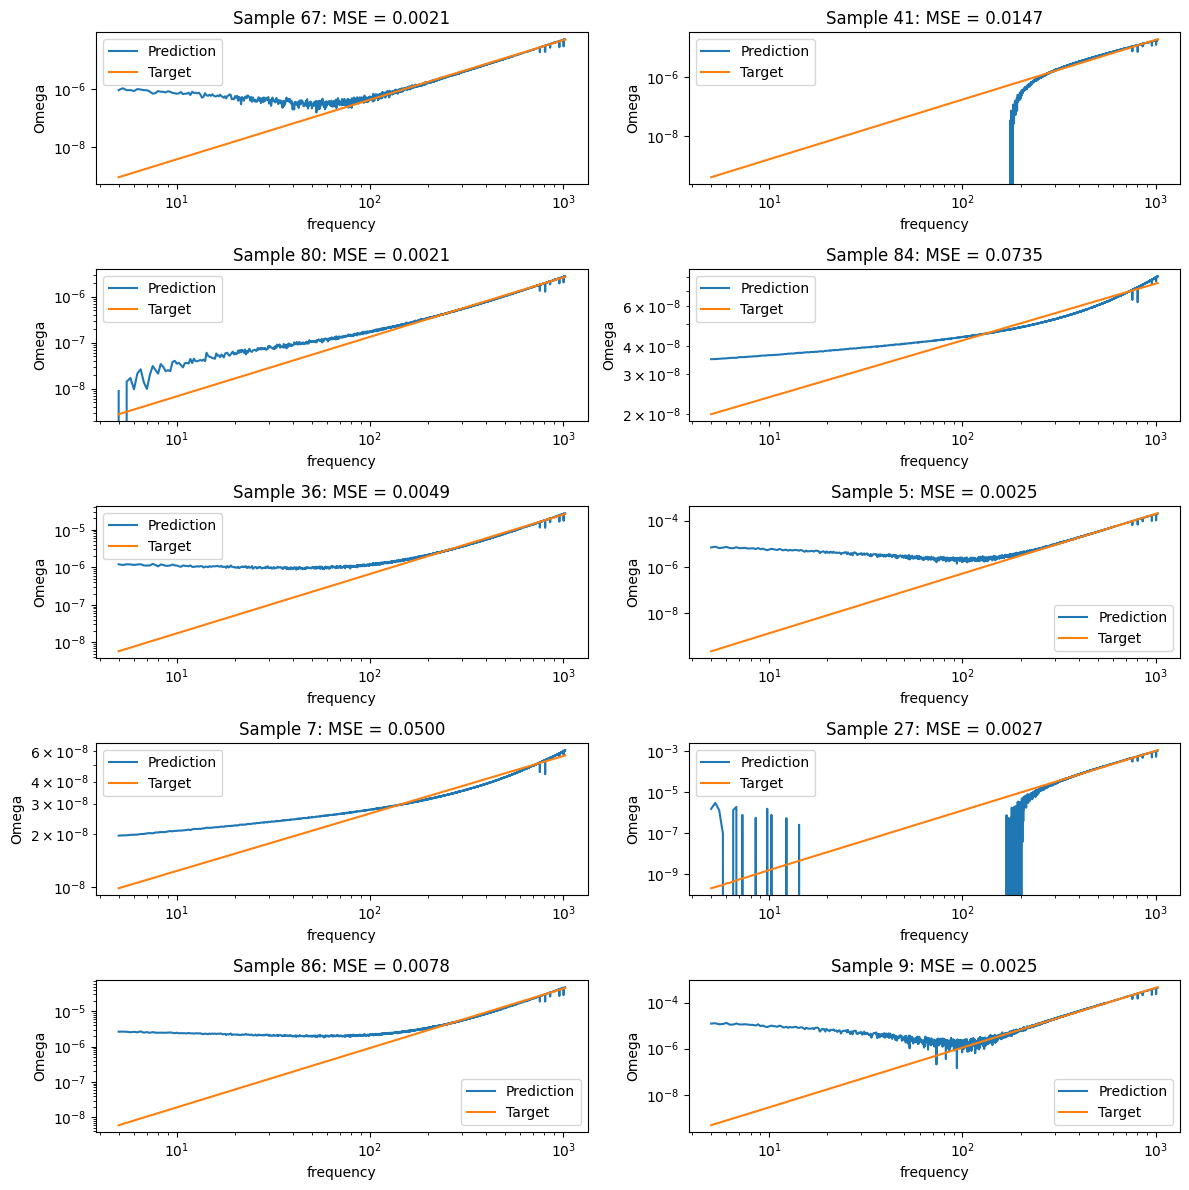

In [ ]:
#Plotting scaled data

import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Randomly select 10 indices
num_samples = 10
random_indices = random.sample(range(len(test_dataset)), num_samples)

# Set up the grid for subplots
num_rows = 5
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    # Extract the sample and corresponding target from test_dataset
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0))  # extract prediction from model output

    # Get unscaled values for target and prediction
    target_sd = target_sds[idx]
    target_mean = target_means[idx]
    noisy_sd = noisy_sds[idx]
    noisy_mean = noisy_means[idx]
    
    unscaled_target = target_sd * target.numpy() + target_mean
    unscaled_prediction = noisy_sd * prediction.squeeze().numpy() + noisy_mean

    # Calculate Mean Squared Error between  target and  prediction
    mse = F.mse_loss(torch.tensor(prediction), torch.tensor(target)).item()

    # Plot unscaled prediction and unscaled target
    axs[row, col].loglog(sim.freq,unscaled_prediction, label='Prediction')
    axs[row, col].loglog(sim.freq,unscaled_target, label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Omega')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

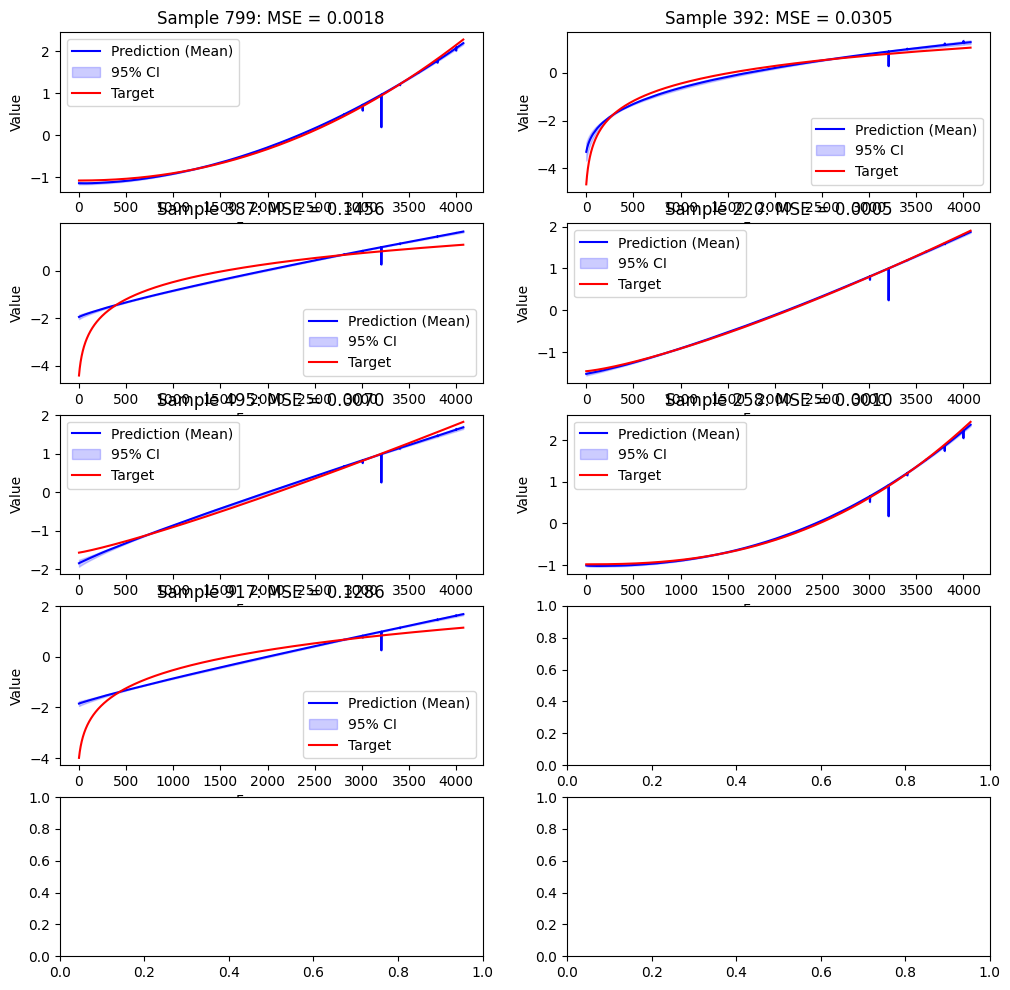

In [ ]:
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]
    samples = []

    for _ in range(10000):  #simulate 10,000 model outputs
        with torch.no_grad():
            model.eval()
            prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0)) 
        samples.append(prediction.squeeze().numpy())  

    samples = np.array(samples)
    samples_mean = np.mean(samples, axis=0)
    samples_std = np.std(samples, axis=0)
     # 95% ci compute
    ci_lower = samples_mean - 1.96 * samples_std
    ci_upper = samples_mean + 1.96 * samples_std

    # calculate mse for each sample
    mse = F.mse_loss(torch.tensor(samples_mean), target).item()

   
    # Plot prediction + target
    axs[row, col].plot(samples_mean, label='Prediction (Mean)', color='blue')
    axs[row, col].fill_between(range(len(samples_mean)), ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    axs[row, col].plot(target.numpy(), label='Target', color='red')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()



# Hide empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()